# Exercise C4

In this notebook excersice, you should implement two variations of the Monte Carlo learning algorithm that was presented in the lecture. 

### README
We recommend you install `gymnasium>=0.28.1` and `python>=3.10.*`. You can set up a python environment using e.g. [conda](https://docs.conda.io/projects/miniconda/en/latest/) in the terminal
```
conda create -n rl23 python=3.10 gymnasium=0.28.1 notebook -c conda-forge
conda activate rl23
```
The `notebook` package is required for opening and working with this jupyter notebook.
In a terminal with the Python environment active, run
```
jupyter notebook sysadmin.ipynb
```

If you need help setting up a development environment, please visit the office hour or ask for help in the forum.

In [3]:
packages_to_install = {
    "gymnasium": "-c conda-forge gymnasium=0.28.1",
    "numpy": "numpy=1.24.0",
    "matplotlib": "matplotlib",
    "scikit-learn": "-c conda-forge scikit-learn",
    "scipy": "-c conda-forge scipy"
}

In [4]:
%%time
import importlib

for package_name, install_command in packages_to_install.items():
    try:
        importlib.import_module(package_name)
        print(f"{package_name} is already installed.")
    except ImportError:
        print(f"{package_name} is not installed. Installing it now...")
        !conda install -y {install_command}

gymnasium is already installed.
numpy is already installed.
matplotlib is already installed.
scikit-learn is not installed. Installing it now...
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



## Package Plan ##

  environment location: /Users/aleksey/anaconda3/envs/hws_ws23

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scikit-learn-1.2.2         |  py310h98c5782_1         6.6 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         6.6 MB

The following packages will be SUPERSEDED by a higher-pr

### Setup

We consider the same learning problem, i.e. the Frozen Lake example. Hence, we create the environment and add the same helpful visualization methods as used in the lecture. 

In [5]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

 
# Create the env which represents an MDP
env = gym.make("FrozenLake-v1",is_slippery=False)

In [6]:
# some useful stuff
def plot_policy(policy):
    """Plot the policy in a grid with arrows."""
    policy_square = np.array(policy).reshape(env.unwrapped.desc.shape)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(np.ones_like(policy_square)*255, cmap='Greys', interpolation='none')
    
    for (i, j), action in np.ndenumerate(policy_square):
        if env.unwrapped.desc[i, j] == b'H':
            ax.text(j, i, 'H', ha='center', va='center', fontsize=12, color='black')
        elif env.unwrapped.desc[i, j] == b'G':
            ax.text(j, i, 'G', ha='center', va='center', fontsize=12, color='green')
        else:  # This will include both 'S' and 'F' tiles.
            if action == 0:  # left
                ax.arrow(j, i, -0.3, 0, head_width=0.2, head_length=0.2, fc='r', ec='r')
            elif action == 1:  # down
                ax.arrow(j, i, 0, 0.3, head_width=0.2, head_length=0.2, fc='r', ec='r')
            elif action == 2:  # right
                ax.arrow(j, i, 0.3, 0, head_width=0.2, head_length=0.2, fc='r', ec='r')
            elif action == 3:  # up
                ax.arrow(j, i, 0, -0.3, head_width=0.2, head_length=0.2, fc='r', ec='r')

    plt.xticks([]), plt.yticks([])
    plt.title('Policy')
    plt.show()
    
    
def ActionToDirection(action):
    if action == 0:
        return "left"
    if action == 1:
        return "down"
    if action == 2:
        return "right"
    if action == 3:
        return "up"
    return "unknown"

## Monte Carlo Control Algorithm from the Lecture

In the following, there for recap again the commented code of the final Monte Carlo Control algorithm from lecture.

Policy after iteration: 0
Got reward 5 times.


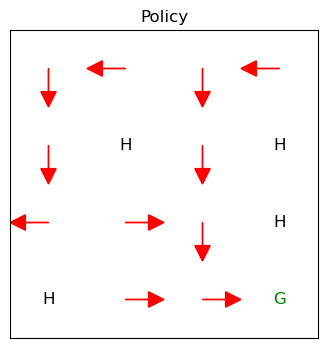

Policy after iteration: 5
Got reward 80 times.


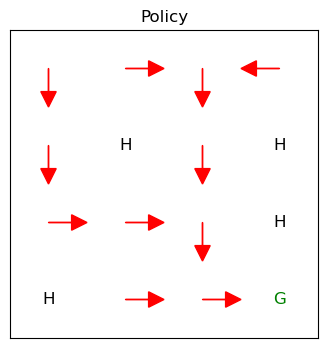

Policy after iteration: 10
Got reward 79 times.


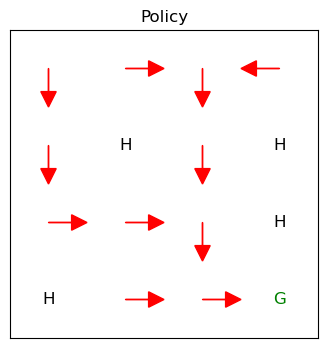

Policy after iteration: 15
Got reward 76 times.


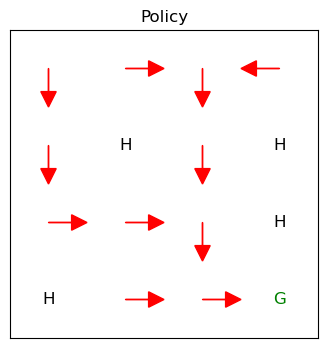

Policy after iteration: 20
Got reward 73 times.


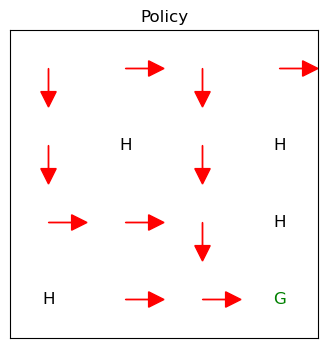

Policy after iteration: 25
Got reward 79 times.


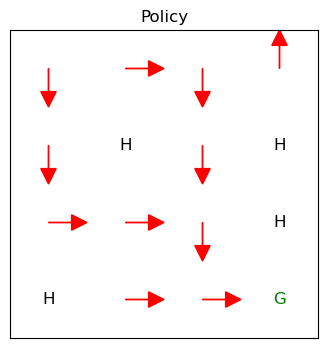

Policy after iteration: 30
Got reward 75 times.


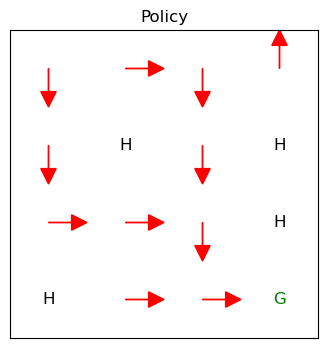

Policy after iteration: 35
Got reward 79 times.


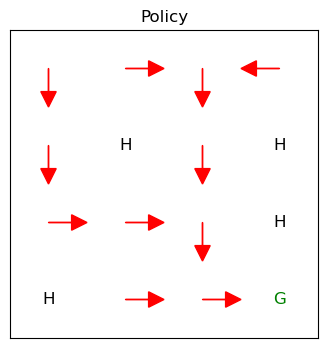

Policy after iteration: 40
Got reward 86 times.


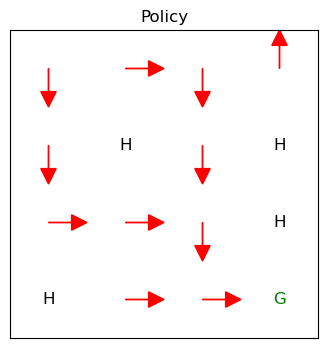

Policy after iteration: 45
Got reward 72 times.


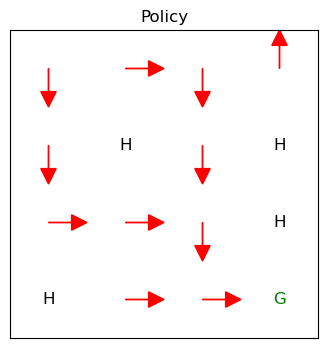

In [10]:
num_states = env.observation_space.n
num_actions = env.action_space.n

# Hyperparameters -> need some tuning
gamma = 0.9
num_iterations = 50 # evaluation-improvement iterations
num_episodes = 100 # number of episodes used to estimate the Q-values

# initialize epsilon to choose action randomly with P(epsilon) during episode generation
epsilon = 0.2

# Initialize a random policy
policy = np.random.randint(num_actions, size=num_states)
#plot_policy(policy)
###########################################################################
################### initialize Q outside the loop! ###################
# array for storing Q-values
Q = np.zeros([num_states, num_actions])


# iterate over policy evaluation and improvement
for iteration in range(num_iterations):
    
    ####### policy evaluation ###################
    episode_count = 0
    steps = 0
    count_got_reward = 0 # count how often goal was reached       
    
    # Initialize cumulative returns and counts outside the episode loop
    returns = {}  # Cumulative returns for each state-action pair across episodes
    count = {}        # Visit counts for each state-action pair
    
    # Policy Evaluation: Estimate Q-values under the current policy
    while episode_count < num_episodes:
        state, _ = env.reset()
        episode = [] # initialize empty episode        
        got_reward = False # variable to check whether we reached the goal in the current episode
        truncated = False
        done = False
        # generate an episode
        while not (truncated or done):  # ensure that episode doesn't run forever because of loops
            steps += 1 # counter for episode length
            
            ####################### Epsilon-greedy policy ##################################
            if np.random.uniform(0, 1) < epsilon:  
                action = env.action_space.sample()
            else:
                action = policy[state]  # Use the current policy             
            
            new_state, reward, done, truncated, _ = env.step(action) # transition to next state
            if reward > 0:
                got_reward = True # episode reached the goal
             
            # store episode
            episode.append((state, action, reward))
            state = new_state
                      
                
        # did this episode reach the goal?
        if got_reward:
            count_got_reward += 1
        episode_count += 1  # Increment the episode counter
        

        # compute the cumulative rewards and sort them according to their start (s,a)
        acc_return = 0
        visited_pairs = set() # track visited state-action pairs in this episode

        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            
            # check if we've seen this state-action pair before in this episode
            if (s, a) not in visited_pairs:
                visited_pairs.add((s, a)) # <-- mark the state-action pair as visited

                # calculate the sum of discounted rewards from timestep t until the end of the episode (sum runs backward)           
                acc_return = r + gamma * acc_return 

                # initialize pair if not yet visited in all episodes of this iteration
                if (s, a) not in returns:
                    returns[(s, a)] = 0
                    count[(s, a)] = 0

                # in the case of several visits, store sum
                returns[(s, a)] += acc_return 
                count[(s, a)] += 1
    
    # cumulative_returns contains now the returns from s,a for all visits on all episodes
    # Update Q-values after each episode
    for (s, a), total_return in returns.items():
        # Calculate average return for state-action pair across all episodes it's been visited
        ###########################################################################
        ############### do an inremental update here! ###############################
        Q[s, a] = Q[s, a]+ 1 / count[(s, a)]*(total_return - Q[s, a])
     
    ####### policy improvement ###################
    for state in range(num_states):
        # replace  policy[state] = np.argmax(Q[state, :]) by
        best_actions = np.argwhere(Q[state] == np.amax(Q[state])).flatten()
        policy[state] = np.random.choice(best_actions)
        
    # plot the policy after after every fifth iteration
    if (iteration % 5 == 0):
        print(f"Policy after iteration: {iteration}")
        print(f"Got reward {count_got_reward} times.")
        plot_policy(policy)

## Exercise C4 (a) (1 Point)

Implement a variation of Monte Carlo Control that uses a linear decay schedule for $\epsilon$. 

More concretely, we assume three hyperparameters to be given: 
- $\epsilon_{\text{start}}$, the start value for $\epsilon$,
- $d$, the value by which $\epsilon$ is decreased after each policy update (decay step size), 
i.e. $$\epsilon \leftarrow \epsilon - d$$ after each policy update, and
- $\epsilon_{\text{min}}$, the minimal value that $\epsilon$ should not fell below, i.e. $\epsilon \geq \epsilon_{\text{min}}$ should always hold.

Extend the Monte Carlo algorithm below with this decay schedule for $\epsilon$ and add explanatory comments at all points of the code that you adapt.

(The algorithm given below is except for the already given initialization of the hyperparameters identical to the Monte Carlo Control algorithm from above.) 

Policy after iteration: 0
Got reward 0 times.


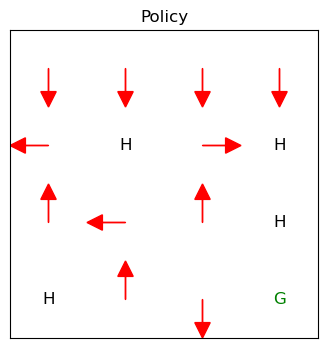

Policy after iteration: 5
Got reward 0 times.


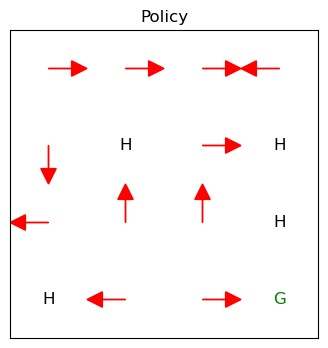

Policy after iteration: 10
Got reward 0 times.


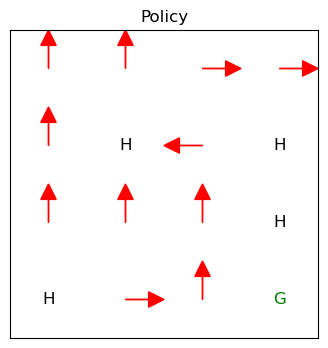

Policy after iteration: 15
Got reward 96 times.


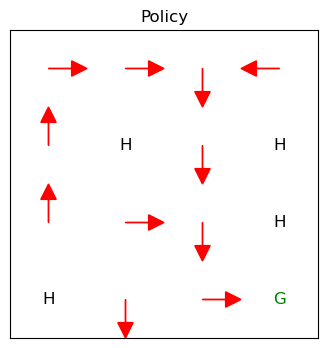

Policy after iteration: 20
Got reward 98 times.


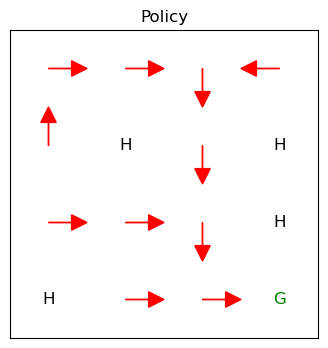

Policy after iteration: 25
Got reward 95 times.


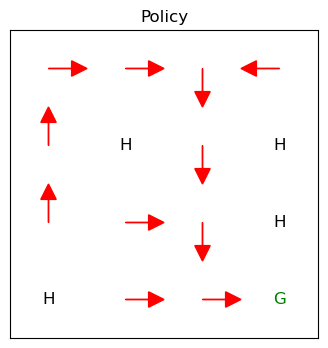

Policy after iteration: 30
Got reward 97 times.


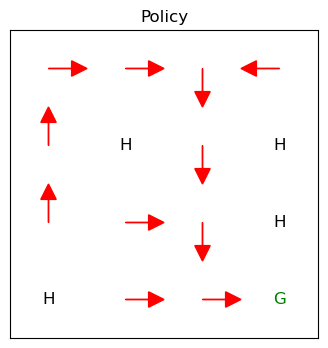

Policy after iteration: 35
Got reward 95 times.


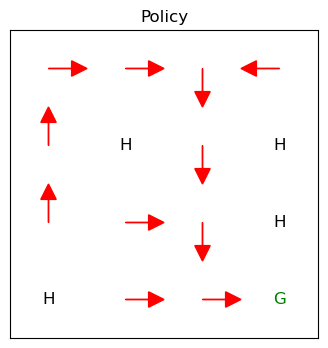

Policy after iteration: 40
Got reward 95 times.


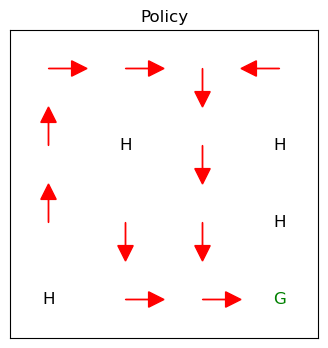

Policy after iteration: 45
Got reward 97 times.


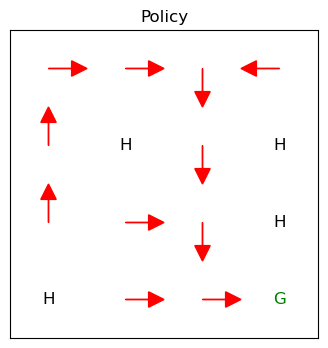

In [16]:
# TODO: Extend this algorithm with linear decay schedule for epsilon

num_states = env.observation_space.n
num_actions = env.action_space.n

gamma = 0.9
num_iterations = 50 
num_episodes = 100 

# Hyperparameter for the decay schedule: 
epsilon_max = 0.5
d = 0.01
epsilon_min = 0.1

policy = np.random.randint(num_actions, size=num_states)

Q = np.zeros([num_states, num_actions])

for iteration in range(num_iterations):
    
    episode_count = 0
    steps = 0
    count_got_reward = 0     

    returns = {}  
    count = {}        
    
    while episode_count < num_episodes:
        state, _ = env.reset()
        episode = []       
        got_reward = False 
        truncated = False
        done = False

        while not (truncated or done):  
            steps += 1 
            
            if np.random.uniform(0, 1) < epsilon:  
                action = env.action_space.sample()
            else:
                action = policy[state]            
            
            new_state, reward, done, truncated, _ = env.step(action)
            if reward > 0:
                got_reward = True 
             
            episode.append((state, action, reward))
            state = new_state
                      
                
        if got_reward:
            count_got_reward += 1
        episode_count += 1  
        
        acc_return = 0
        visited_pairs = set() 

        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            
            if (s, a) not in visited_pairs:
                visited_pairs.add((s, a)) 
                acc_return = r + gamma * acc_return 

                if (s, a) not in returns:
                    returns[(s, a)] = 0
                    count[(s, a)] = 0

                returns[(s, a)] += acc_return 
                count[(s, a)] += 1
    
    for (s, a), total_return in returns.items():
        Q[s, a] = Q[s, a]+ 1 / count[(s, a)]*(total_return - Q[s, a])
     
    for state in range(num_states):
        best_actions = np.argwhere(Q[state] == np.amax(Q[state])).flatten()
        policy[state] = np.random.choice(best_actions)
        
    if (iteration % 5 == 0):
        print(f"Policy after iteration: {iteration}")
        print(f"Got reward {count_got_reward} times.")
        plot_policy(policy)
    
    # Only if epsilon is larger than epsilon_min then update epsilon
    if epsilon >= epsilon_min:
        epsilon = epsilon - d


## Exercise C4 (b) (2 Points)

Implement a variation of Monte Carlo Control that is extended with a convergency check. 

More concretely, we assume a hyperparameter $\delta > 0$ to be given. If the maximum change in the action value function for all state-action pair in an iteration is less than $\delta$, then the algorithm should immediately terminate.

Extend the Monte Carlo algorithm below with this convergency check and add again explanatory comments at all points of the code that you adapt.

Q_max:0.0
Q for cycle finished
Policy after iteration: 0
Got reward 0 times.


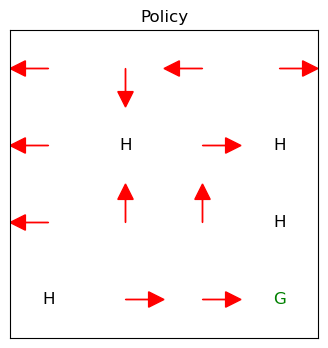

Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Policy after iteration: 5
Got reward 0 times.


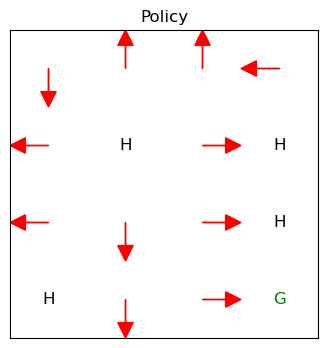

Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Policy after iteration: 10
Got reward 0 times.


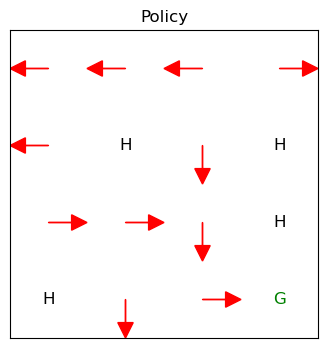

Q_max:0.08136361710000004
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Policy after iteration: 15
Got reward 0 times.


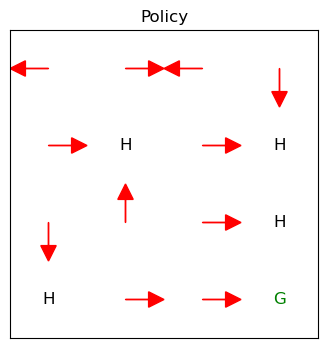

Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Policy after iteration: 20
Got reward 0 times.


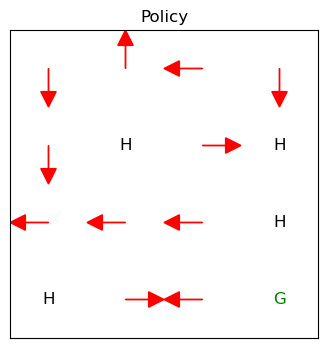

Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Policy after iteration: 25
Got reward 4 times.


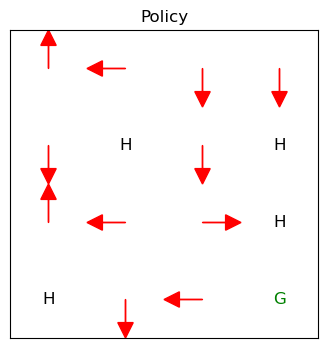

Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.11105907600581637
Q for cycle finished
Q_max:0.0
Q for cycle finished
Policy after iteration: 30
Got reward 0 times.


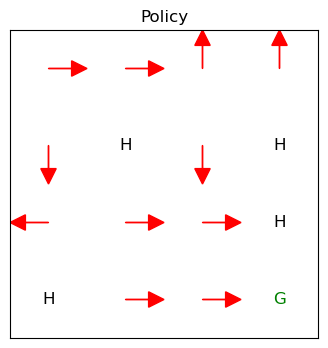

Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Policy after iteration: 35
Got reward 0 times.


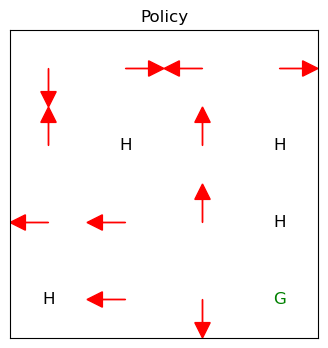

Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Policy after iteration: 40
Got reward 0 times.


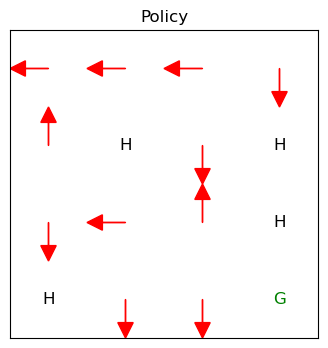

Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Policy after iteration: 45
Got reward 0 times.


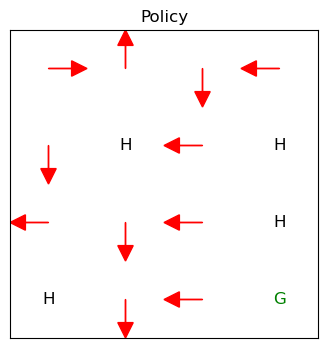

Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Policy after iteration: 50
Got reward 0 times.


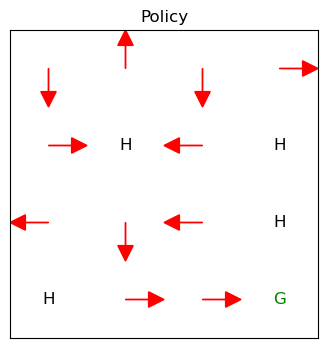

Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Policy after iteration: 55
Got reward 0 times.


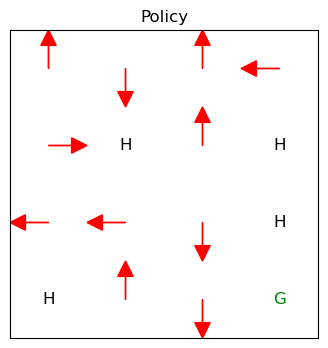

Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Policy after iteration: 60
Got reward 0 times.


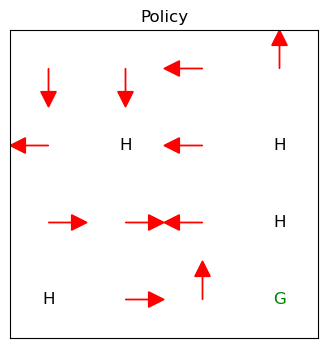

Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Policy after iteration: 65
Got reward 0 times.


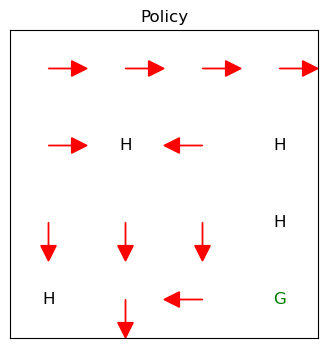

Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:0.0
Q for cycle finished
Policy after iteration: 70
Got reward 0 times.


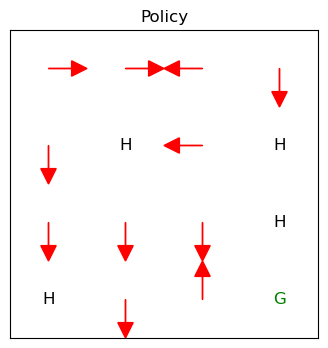

Q_max:0.0
Q for cycle finished
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q_max:1.0
Q for cycle finished
Q_max:1.989247311827957
Q_max:1.989247311827957
Q_max:1.989247311827957
Q_max:1.989247311827957
Q_max:1.989247311827957
Q_max:1.989247311827957
Q_max:1.989247311827957
Q_max:1.989247311827957
Q_max:1.989247311827957
Q_max:1.989247311827957
Q_max:1.989247311827957
Q_max:1.989247311827957
Q_max:1.989247311827957
Q_max:1.989247311827957
Q_max:1.989247311827957
Q_max:1.989247311827957
Q_max:1.989247311827957
Q_max:1.989247311827957
Q_max:1.989247311827957
Q_max:1.989247311827957
Q for cycle finished
Q_max:2.9689488698705286
Q_max:2.9689488698705286
Q_max:2.9689488698705286
Q_max:2.9689488698705286
Q_max:2.9689488698705286
Q_max:2.9689488698705286
Q_max:2.9689488698705286
Q_max:2.96894886987052

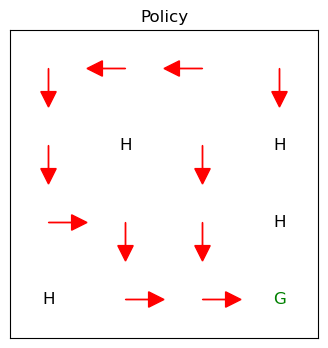

Q_max:4.898642095951284
Q_max:4.898642095951284
Q_max:4.898642095951284
Q_max:4.898642095951284
Q_max:4.898642095951284
Q_max:4.898642095951284
Q_max:4.898642095951284
Q_max:4.898642095951284
Q_max:4.898642095951284
Q_max:4.898642095951284
Q_max:4.898642095951284
Q_max:4.898642095951284
Q_max:4.898642095951284
Q_max:4.898642095951284
Q_max:4.898642095951284
Q_max:4.898642095951284
Q_max:4.898642095951284
Q_max:4.898642095951284
Q for cycle finished
Q_max:5.847077442309692
Q_max:5.847077442309692
Q_max:5.847077442309692
Q_max:5.847077442309692
Q_max:5.847077442309692
Q_max:5.847077442309692
Q_max:5.847077442309692
Q_max:5.847077442309692
Q_max:5.847077442309692
Q_max:5.847077442309692
Q_max:5.847077442309692
Q_max:5.847077442309692
Q_max:5.847077442309692
Q_max:5.847077442309692
Q_max:5.847077442309692
Q_max:5.847077442309692
Q_max:5.847077442309692
Q_max:5.847077442309692
Q_max:5.847077442309692
Q_max:5.847077442309692
Q_max:5.847077442309692
Q for cycle finished
Q_max:6.78420564185474

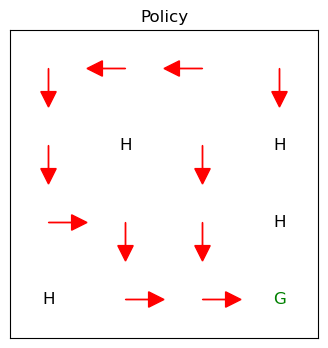

Q_max:9.538558497348363
Q_max:9.538558497348363
Q_max:9.538558497348363
Q_max:9.538558497348363
Q_max:9.538558497348363
Q_max:9.538558497348363
Q_max:9.538558497348363
Q_max:9.538558497348363
Q_max:9.538558497348363
Q_max:9.538558497348363
Q_max:9.538558497348363
Q_max:9.538558497348363
Q_max:9.538558497348363
Q_max:9.538558497348363
Q_max:9.538558497348363
Q_max:9.538558497348363
Q_max:9.538558497348363
Q_max:9.538558497348363
Q_max:9.538558497348363
Q_max:9.538558497348363
Q for cycle finished
Q_max:10.440222842736524
Q_max:10.440222842736524
Q_max:10.440222842736524
Q_max:10.440222842736524
Q_max:10.440222842736524
Q_max:10.440222842736524
Q_max:10.440222842736524
Q_max:10.440222842736524
Q_max:10.440222842736524
Q_max:10.440222842736524
Q_max:10.440222842736524
Q_max:10.440222842736524
Q_max:10.440222842736524
Q_max:10.440222842736524
Q_max:10.440222842736524
Q_max:10.440222842736524
Q_max:10.440222842736524
Q_max:10.440222842736524
Q_max:10.440222842736524
Q for cycle finished
Q_m

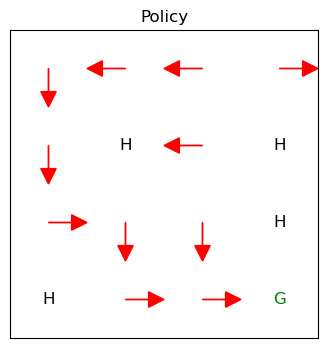

Q_max:13.951225039231453
Q_max:13.951225039231453
Q_max:13.951225039231453
Q_max:13.951225039231453
Q_max:13.951225039231453
Q_max:13.951225039231453
Q_max:13.951225039231453
Q_max:13.951225039231453
Q_max:13.951225039231453
Q_max:13.951225039231453
Q_max:13.951225039231453
Q_max:13.951225039231453
Q_max:13.951225039231453
Q_max:13.951225039231453
Q_max:13.951225039231453
Q_max:13.951225039231453
Q_max:13.951225039231453
Q_max:13.951225039231453
Q_max:13.951225039231453
Q_max:13.951225039231453
Q_max:13.951225039231453
Q_max:13.951225039231453
Q for cycle finished
Q_max:14.807397976971334
Q_max:14.807397976971334
Q_max:14.807397976971334
Q_max:14.807397976971334
Q_max:14.807397976971334
Q_max:14.807397976971334
Q_max:14.807397976971334
Q_max:14.807397976971334
Q_max:14.807397976971334
Q_max:14.807397976971334
Q_max:14.807397976971334
Q_max:14.807397976971334
Q_max:14.807397976971334
Q_max:14.807397976971334
Q_max:14.807397976971334
Q_max:14.807397976971334
Q_max:14.807397976971334
Q_ma

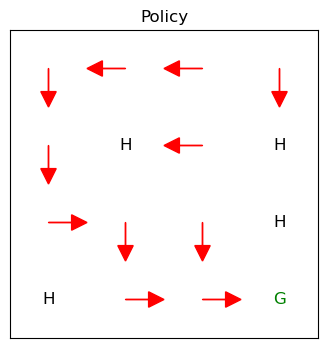

Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q_max:18.130768254662506
Q for cycle finished
Q_max:18.941906085343106
Q_max:18.941906085343106
Q_max:18.941906085343106
Q_max:18.941906085343106
Q_max:18.941906085343106
Q_max:18.941906085343106
Q_max:18.941906085343106
Q_max:18.941906085343106
Q_max:18.941906085343106
Q_max:18.941906085343106
Q_max:18.941906085343106
Q_max:18.941906085343106
Q_max:18.941906085343106
Q_max:18.941906085343106
Q_max:18.941906085343106
Q_ma

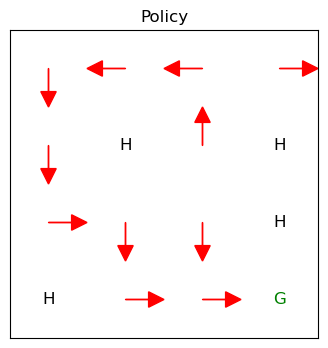

Q_max:22.1126935633297
Q_max:22.1126935633297
Q_max:22.1126935633297
Q_max:22.1126935633297
Q_max:22.1126935633297
Q_max:22.1126935633297
Q_max:22.1126935633297
Q_max:22.1126935633297
Q_max:22.1126935633297
Q_max:22.1126935633297
Q_max:22.1126935633297
Q_max:22.1126935633297
Q_max:22.1126935633297
Q_max:22.1126935633297
Q_max:22.1126935633297
Q_max:22.1126935633297
Q_max:22.1126935633297
Q_max:22.1126935633297
Q_max:22.1126935633297
Q_max:22.1126935633297
Q_max:22.1126935633297
Q for cycle finished
Q_max:22.877452142443214
Q_max:22.877452142443214
Q_max:22.877452142443214
Q_max:22.877452142443214
Q_max:22.877452142443214
Q_max:22.877452142443214
Q_max:22.877452142443214
Q_max:22.877452142443214
Q_max:22.877452142443214
Q_max:22.877452142443214
Q_max:22.877452142443214
Q_max:22.877452142443214
Q_max:22.877452142443214
Q_max:22.877452142443214
Q_max:22.877452142443214
Q_max:22.877452142443214
Q_max:22.877452142443214
Q_max:22.877452142443214
Q_max:22.877452142443214
Q_max:22.877452142443

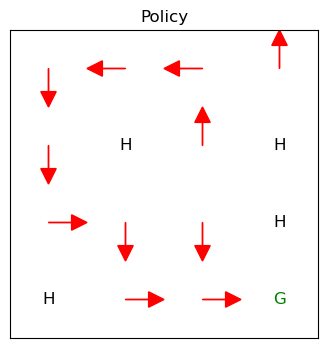

Q_max:25.863769009840386
Q_max:25.863769009840386
Q_max:25.863769009840386
Q_max:25.863769009840386
Q_max:25.863769009840386
Q_max:25.863769009840386
Q_max:25.863769009840386
Q_max:25.863769009840386
Q_max:25.863769009840386
Q_max:25.863769009840386
Q_max:25.863769009840386
Q_max:25.863769009840386
Q_max:25.863769009840386
Q_max:25.863769009840386
Q_max:25.863769009840386
Q_max:25.863769009840386
Q_max:25.863769009840386
Q_max:25.863769009840386
Q_max:25.863769009840386
Q_max:25.863769009840386
Q for cycle finished
Q_max:26.588622531012298
Q_max:26.588622531012298
Q_max:26.588622531012298
Q_max:26.588622531012298
Q_max:26.588622531012298
Q_max:26.588622531012298
Q_max:26.588622531012298
Q_max:26.588622531012298
Q_max:26.588622531012298
Q_max:26.588622531012298
Q_max:26.588622531012298
Q_max:26.588622531012298
Q_max:26.588622531012298
Q_max:26.588622531012298
Q_max:26.588622531012298
Q_max:26.588622531012298
Q_max:26.588622531012298
Q_max:26.588622531012298
Q_max:26.588622531012298
Q_ma

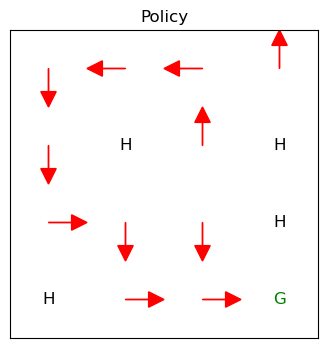

Q_max:29.425866438978876
Q_max:29.425866438978876
Q_max:29.425866438978876
Q_max:29.425866438978876
Q_max:29.425866438978876
Q_max:29.425866438978876
Q_max:29.425866438978876
Q_max:29.425866438978876
Q_max:29.425866438978876
Q_max:29.425866438978876
Q_max:29.425866438978876
Q_max:29.425866438978876
Q_max:29.425866438978876
Q_max:29.425866438978876
Q_max:29.425866438978876
Q_max:29.425866438978876
Q_max:29.425866438978876
Q_max:29.425866438978876
Q_max:29.425866438978876
Q_max:29.425866438978876
Q_max:29.425866438978876
Q_max:29.425866438978876
Q_max:29.425866438978876
Q for cycle finished
Q_max:30.10602006464215
Q_max:30.10602006464215
Q_max:30.10602006464215
Q_max:30.10602006464215
Q_max:30.10602006464215
Q_max:30.10602006464215
Q_max:30.10602006464215
Q_max:30.10602006464215
Q_max:30.10602006464215
Q_max:30.10602006464215
Q_max:30.10602006464215
Q_max:30.10602006464215
Q_max:30.10602006464215
Q_max:30.10602006464215
Q_max:30.10602006464215
Q_max:30.10602006464215
Q_max:30.10602006464

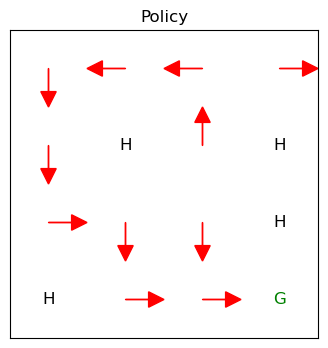

Q_max:32.76065248069938
Q_max:32.76065248069938
Q_max:32.76065248069938
Q_max:32.76065248069938
Q_max:32.76065248069938
Q_max:32.76065248069938
Q_max:32.76065248069938
Q_max:32.76065248069938
Q_max:32.76065248069938
Q_max:32.76065248069938
Q_max:32.76065248069938
Q_max:32.76065248069938
Q_max:32.76065248069938
Q_max:32.76065248069938
Q_max:32.76065248069938
Q_max:32.76065248069938
Q_max:32.76065248069938
Q_max:32.76065248069938
Q for cycle finished
Q_max:33.40838740026175
Q_max:33.40838740026175
Q_max:33.40838740026175
Q_max:33.40838740026175
Q_max:33.40838740026175
Q_max:33.40838740026175
Q_max:33.40838740026175
Q_max:33.40838740026175
Q_max:33.40838740026175
Q_max:33.40838740026175
Q_max:33.40838740026175
Q_max:33.40838740026175
Q_max:33.40838740026175
Q_max:33.40838740026175
Q_max:33.40838740026175
Q_max:33.40838740026175
Q_max:33.40838740026175
Q_max:33.40838740026175
Q_max:33.40838740026175
Q_max:33.40838740026175
Q for cycle finished
Q_max:34.04915742821593
Q_max:34.0491574282159

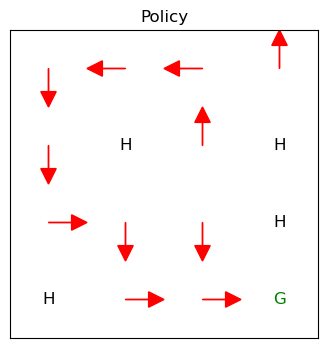

Q_max:0.0
Q for cycle finished
Q_max:35.31406897229644
Q_max:35.31406897229644
Q_max:35.31406897229644
Q_max:35.31406897229644
Q_max:35.31406897229644
Q_max:35.31406897229644
Q_max:35.31406897229644
Q_max:35.31406897229644
Q_max:35.31406897229644
Q_max:35.31406897229644
Q_max:35.31406897229644
Q_max:35.31406897229644
Q_max:35.31406897229644
Q_max:35.31406897229644
Q_max:35.31406897229644
Q_max:35.31406897229644
Q_max:35.31406897229644
Q_max:35.31406897229644
Q_max:35.31406897229644
Q_max:35.31406897229644
Q for cycle finished
Q_max:35.930220396510606
Q_max:35.930220396510606
Q_max:35.930220396510606
Q_max:35.930220396510606
Q_max:35.930220396510606
Q_max:35.930220396510606
Q_max:35.930220396510606
Q_max:35.930220396510606
Q_max:35.930220396510606
Q_max:35.930220396510606
Q_max:35.930220396510606
Q_max:35.930220396510606
Q_max:35.930220396510606
Q_max:35.930220396510606
Q_max:35.930220396510606
Q_max:35.930220396510606
Q_max:35.930220396510606
Q_max:35.930220396510606
Q_max:35.930220396

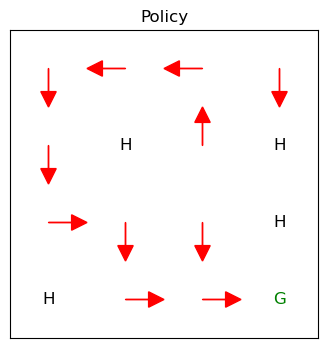

Q_max:37.76370268541013
Q_max:37.76370268541013
Q_max:37.76370268541013
Q_max:37.76370268541013
Q_max:37.76370268541013
Q_max:37.76370268541013
Q_max:37.76370268541013
Q_max:37.76370268541013
Q_max:37.76370268541013
Q_max:37.76370268541013
Q_max:37.76370268541013
Q_max:37.76370268541013
Q_max:37.76370268541013
Q_max:37.76370268541013
Q_max:37.76370268541013
Q_max:37.76370268541013
Q_max:37.76370268541013
Q_max:37.76370268541013
Q_max:37.76370268541013
Q_max:37.76370268541013
Q_max:37.76370268541013
Q_max:37.76370268541013
Q for cycle finished
Q_max:38.34871694161441
Q_max:38.34871694161441
Q_max:38.34871694161441
Q_max:38.34871694161441
Q_max:38.34871694161441
Q_max:38.34871694161441
Q_max:38.34871694161441
Q_max:38.34871694161441
Q_max:38.34871694161441
Q_max:38.34871694161441
Q_max:38.34871694161441
Q_max:38.34871694161441
Q_max:38.34871694161441
Q_max:38.34871694161441
Q_max:38.34871694161441
Q_max:38.34871694161441
Q_max:38.34871694161441
Q_max:38.34871694161441
Q_max:38.3487169416

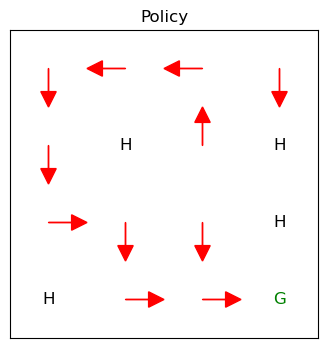

Q_max:40.11707394425497
Q_max:40.11707394425497
Q_max:40.11707394425497
Q_max:40.11707394425497
Q_max:40.11707394425497
Q_max:40.11707394425497
Q_max:40.11707394425497
Q_max:40.11707394425497
Q_max:40.11707394425497
Q_max:40.11707394425497
Q_max:40.11707394425497
Q_max:40.11707394425497
Q_max:40.11707394425497
Q_max:40.11707394425497
Q_max:40.11707394425497
Q_max:40.11707394425497
Q_max:40.11707394425497
Q_max:40.11707394425497
Q_max:40.11707394425497
Q_max:40.11707394425497
Q_max:40.11707394425497
Q for cycle finished
Q_max:40.70349586235543
Q_max:40.70349586235543
Q_max:40.70349586235543
Q_max:40.70349586235543
Q_max:40.70349586235543
Q_max:40.70349586235543
Q_max:40.70349586235543
Q_max:40.70349586235543
Q_max:40.70349586235543
Q_max:40.70349586235543
Q_max:40.70349586235543
Q_max:40.70349586235543
Q_max:40.70349586235543
Q_max:40.70349586235543
Q_max:40.70349586235543
Q_max:40.70349586235543
Q_max:40.70349586235543
Q_max:40.70349586235543
Q for cycle finished
Q_max:41.2838721936713

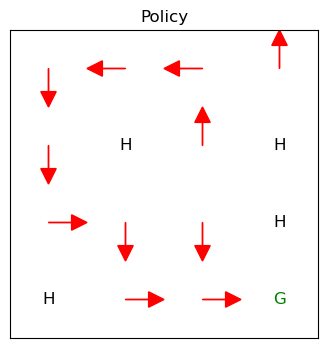

Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q_max:42.38988533932443
Q for cycle finished
Q_max:42.92912571607091
Q_max:42.92912571607091
Q_max:42.92912571607091
Q_max:42.92912571607091
Q_max:42.92912571607091
Q_max:42.92912571607091
Q_max:42.92912571607091
Q_max:42.92912571607091
Q_max:42.92912571607091
Q_max:42.92912571607091
Q_max:42.92912571607091
Q_max:42.92912571607091
Q_max:42.92912571607091
Q_max:42.92912571607091
Q_max:42.92912571607091
Q_max:42.92912571607091
Q_max:42.9291257160

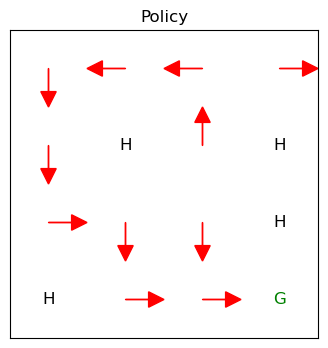

Q_max:45.11913662429267
Q_max:45.11913662429267
Q_max:45.11913662429267
Q_max:45.11913662429267
Q_max:45.11913662429267
Q_max:45.11913662429267
Q_max:45.11913662429267
Q_max:45.11913662429267
Q_max:45.11913662429267
Q_max:45.11913662429267
Q_max:45.11913662429267
Q_max:45.11913662429267
Q_max:45.11913662429267
Q_max:45.11913662429267
Q_max:45.11913662429267
Q_max:45.11913662429267
Q_max:45.11913662429267
Q_max:45.11913662429267
Q_max:45.11913662429267
Q_max:45.11913662429267
Q_max:45.11913662429267
Q for cycle finished
Q_max:45.64914561778962
Q_max:45.64914561778962
Q_max:45.64914561778962
Q_max:45.64914561778962
Q_max:45.64914561778962
Q_max:45.64914561778962
Q_max:45.64914561778962
Q_max:45.64914561778962
Q_max:45.64914561778962
Q_max:45.64914561778962
Q_max:45.64914561778962
Q_max:45.64914561778962
Q_max:45.64914561778962
Q_max:45.64914561778962
Q_max:45.64914561778962
Q_max:45.64914561778962
Q_max:45.64914561778962
Q_max:45.64914561778962
Q_max:45.64914561778962
Q_max:45.6491456177

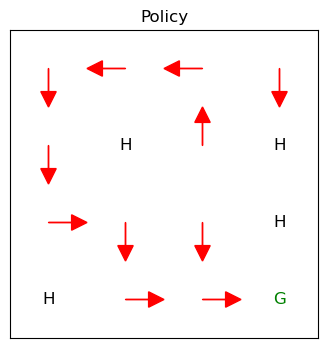

Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q_max:47.66673500181212
Q for cycle finished
Q_max:48.15418946415823
Q_max:48.15418946415823
Q_max:48.15418946415823
Q_max:48.15418946415823
Q_max:48.15418946415823
Q_max:48.15418946415823
Q_max:48.15418946415823
Q_max:48.15418946415823
Q_max:48.15418946415823
Q_max:48.15418946415823
Q_max:48.15418946415823
Q_max:48.15418946415823
Q_max:48.15418946415823
Q_max:48.15418946415823
Q_max:48.15418946415823
Q_max:48.15418946415823
Q_max:48.1541894641

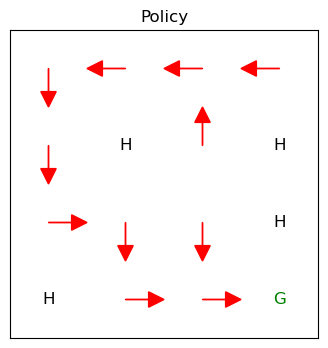

Q_max:50.07914877148348
Q_max:50.07914877148348
Q_max:50.07914877148348
Q_max:50.07914877148348
Q_max:50.07914877148348
Q_max:50.07914877148348
Q_max:50.07914877148348
Q_max:50.07914877148348
Q_max:50.07914877148348
Q_max:50.07914877148348
Q_max:50.07914877148348
Q_max:50.07914877148348
Q_max:50.07914877148348
Q_max:50.07914877148348
Q_max:50.07914877148348
Q_max:50.07914877148348
Q_max:50.07914877148348
Q_max:50.07914877148348
Q_max:50.07914877148348
Q_max:50.07914877148348
Q_max:50.07914877148348
Q for cycle finished
Q_max:50.54066330082237
Q_max:50.54066330082237
Q_max:50.54066330082237
Q_max:50.54066330082237
Q_max:50.54066330082237
Q_max:50.54066330082237
Q_max:50.54066330082237
Q_max:50.54066330082237
Q_max:50.54066330082237
Q_max:50.54066330082237
Q_max:50.54066330082237
Q_max:50.54066330082237
Q_max:50.54066330082237
Q_max:50.54066330082237
Q_max:50.54066330082237
Q_max:50.54066330082237
Q_max:50.54066330082237
Q_max:50.54066330082237
Q_max:50.54066330082237
Q_max:50.5406633008

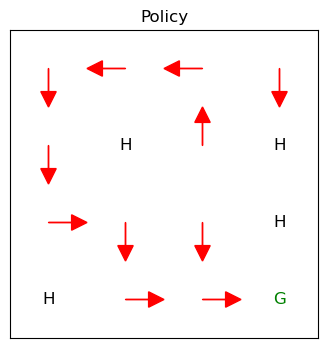

Q_max:52.40506145680516
Q_max:52.40506145680516
Q_max:52.40506145680516
Q_max:52.40506145680516
Q_max:52.40506145680516
Q_max:52.40506145680516
Q_max:52.40506145680516
Q_max:52.40506145680516
Q_max:52.40506145680516
Q_max:52.40506145680516
Q_max:52.40506145680516
Q_max:52.40506145680516
Q_max:52.40506145680516
Q_max:52.40506145680516
Q_max:52.40506145680516
Q_max:52.40506145680516
Q_max:52.40506145680516
Q_max:52.40506145680516
Q_max:52.40506145680516
Q_max:52.40506145680516
Q_max:52.40506145680516
Q for cycle finished
Q_max:52.84156617232338
Q_max:52.84156617232338
Q_max:52.84156617232338
Q_max:52.84156617232338
Q_max:52.84156617232338
Q_max:52.84156617232338
Q_max:52.84156617232338
Q_max:52.84156617232338
Q_max:52.84156617232338
Q_max:52.84156617232338
Q_max:52.84156617232338
Q_max:52.84156617232338
Q_max:52.84156617232338
Q_max:52.84156617232338
Q_max:52.84156617232338
Q_max:52.84156617232338
Q_max:52.84156617232338
Q_max:52.84156617232338
Q_max:52.84156617232338
Q_max:52.8415661723

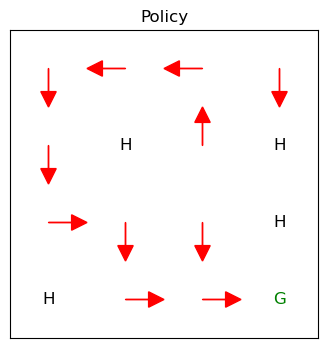

Q_max:54.563078184721505
Q_max:54.563078184721505
Q_max:54.563078184721505
Q_max:54.563078184721505
Q_max:54.563078184721505
Q_max:54.563078184721505
Q_max:54.563078184721505
Q_max:54.563078184721505
Q_max:54.563078184721505
Q_max:54.563078184721505
Q_max:54.563078184721505
Q_max:54.563078184721505
Q_max:54.563078184721505
Q_max:54.563078184721505
Q_max:54.563078184721505
Q_max:54.563078184721505
Q_max:54.563078184721505
Q_max:54.563078184721505
Q_max:54.563078184721505
Q_max:54.563078184721505
Q_max:54.563078184721505
Q for cycle finished
Q_max:54.97000124793105
Q_max:54.97000124793105
Q_max:54.97000124793105
Q_max:54.97000124793105
Q_max:54.97000124793105
Q_max:54.97000124793105
Q_max:54.97000124793105
Q_max:54.97000124793105
Q_max:54.97000124793105
Q_max:54.97000124793105
Q_max:54.97000124793105
Q_max:54.97000124793105
Q_max:54.97000124793105
Q_max:54.97000124793105
Q_max:54.97000124793105
Q_max:54.97000124793105
Q_max:54.97000124793105
Q_max:54.97000124793105
Q_max:54.9700012479310

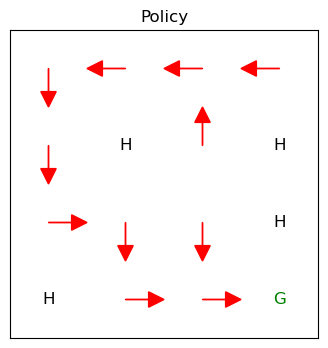

Q_max:56.6412510102169
Q_max:56.6412510102169
Q_max:56.6412510102169
Q_max:56.6412510102169
Q_max:56.6412510102169
Q_max:56.6412510102169
Q_max:56.6412510102169
Q_max:56.6412510102169
Q_max:56.6412510102169
Q_max:56.6412510102169
Q_max:56.6412510102169
Q_max:56.6412510102169
Q_max:56.6412510102169
Q_max:56.6412510102169
Q_max:56.6412510102169
Q_max:56.6412510102169
Q_max:56.6412510102169
Q_max:56.6412510102169
Q_max:56.6412510102169
Q_max:56.6412510102169
Q for cycle finished
Q_max:57.05732058743116
Q_max:57.05732058743116
Q_max:57.05732058743116
Q_max:57.05732058743116
Q_max:57.05732058743116
Q_max:57.05732058743116
Q_max:57.05732058743116
Q_max:57.05732058743116
Q_max:57.05732058743116
Q_max:57.05732058743116
Q_max:57.05732058743116
Q_max:57.05732058743116
Q_max:57.05732058743116
Q_max:57.05732058743116
Q_max:57.05732058743116
Q_max:57.05732058743116
Q_max:57.05732058743116
Q_max:57.05732058743116
Q_max:57.05732058743116
Q_max:57.05732058743116
Q for cycle finished
Q_max:57.462973497

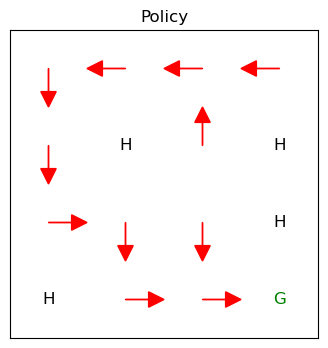

Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q_max:58.60974804403701
Q for cycle finished
Q_max:58.97953569947747
Q_max:58.97953569947747
Q_max:58.97953569947747
Q_max:58.97953569947747
Q_max:58.97953569947747
Q_max:58.97953569947747
Q_max:58.97953569947747
Q_max:58.97953569947747
Q_max:58.97953569947747
Q_max:58.97953569947747
Q_max:58.97953569947747
Q_max:58.97953569947747
Q_max:58.97953569947747
Q_max:58.97953569947747
Q_max:58.97953569947747
Q_max:58.97953569947747
Q_max:58.9795356994

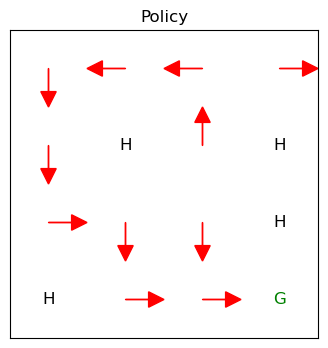

Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q_max:60.47254231684811
Q for cycle finished
Q_max:60.85547555851293
Q_max:60.85547555851293
Q_max:60.85547555851293
Q_max:60.85547555851293
Q_max:60.85547555851293
Q_max:60.85547555851293
Q_max:60.85547555851293
Q_max:60.85547555851293
Q_max:60.85547555851293
Q_max:60.85547555851293
Q_max:60.85547555851293
Q_max:60.85547555851293
Q_max:60.85547555851293
Q_max:60.85547555851293
Q_max:60.85547555851293
Q_max:60.85547555851293
Q_max:60.8554755585

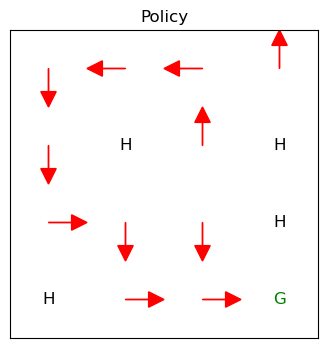

Q_max:62.263494263570884
Q_max:62.263494263570884
Q_max:62.263494263570884
Q_max:62.263494263570884
Q_max:62.263494263570884
Q_max:62.263494263570884
Q_max:62.263494263570884
Q_max:62.263494263570884
Q_max:62.263494263570884
Q_max:62.263494263570884
Q_max:62.263494263570884
Q_max:62.263494263570884
Q_max:62.263494263570884
Q_max:62.263494263570884
Q_max:62.263494263570884
Q_max:62.263494263570884
Q_max:62.263494263570884
Q_max:62.263494263570884
Q_max:62.263494263570884
Q_max:62.263494263570884
Q_max:62.263494263570884
Q for cycle finished
Q_max:62.593994325252915
Q_max:62.593994325252915
Q_max:62.593994325252915
Q_max:62.593994325252915
Q_max:62.593994325252915
Q_max:62.593994325252915
Q_max:62.593994325252915
Q_max:62.593994325252915
Q_max:62.593994325252915
Q_max:62.593994325252915
Q_max:62.593994325252915
Q_max:62.593994325252915
Q_max:62.593994325252915
Q_max:62.593994325252915
Q_max:62.593994325252915
Q_max:62.593994325252915
Q_max:62.593994325252915
Q_max:62.593994325252915
Q fo

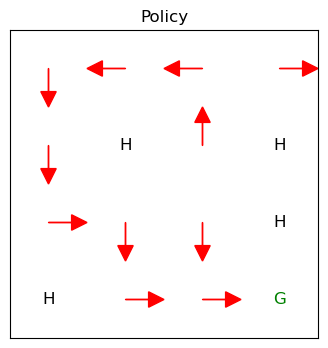

Q_max:63.948076154696025
Q_max:63.948076154696025
Q_max:63.948076154696025
Q_max:63.948076154696025
Q_max:63.948076154696025
Q_max:63.948076154696025
Q_max:63.948076154696025
Q_max:63.948076154696025
Q_max:63.948076154696025
Q_max:63.948076154696025
Q_max:63.948076154696025
Q_max:63.948076154696025
Q_max:63.948076154696025
Q_max:63.948076154696025
Q_max:63.948076154696025
Q_max:63.948076154696025
Q_max:63.948076154696025
Q_max:63.948076154696025
Q_max:63.948076154696025
Q_max:63.948076154696025
Q_max:63.948076154696025
Q for cycle finished
Q_max:64.28195036141794
Q_max:64.28195036141794
Q_max:64.28195036141794
Q_max:64.28195036141794
Q_max:64.28195036141794
Q_max:64.28195036141794
Q_max:64.28195036141794
Q_max:64.28195036141794
Q_max:64.28195036141794
Q_max:64.28195036141794
Q_max:64.28195036141794
Q_max:64.28195036141794
Q_max:64.28195036141794
Q_max:64.28195036141794
Q_max:64.28195036141794
Q_max:64.28195036141794
Q_max:64.28195036141794
Q_max:64.28195036141794
Q_max:64.2819503614179

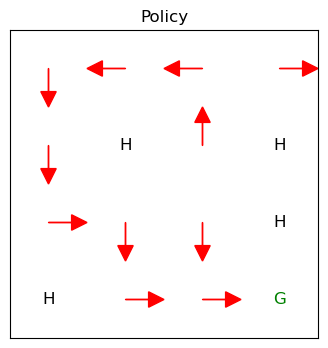

Q_max:65.53319133929801
Q_max:65.53319133929801
Q_max:65.53319133929801
Q_max:65.53319133929801
Q_max:65.53319133929801
Q_max:65.53319133929801
Q_max:65.53319133929801
Q_max:65.53319133929801
Q_max:65.53319133929801
Q_max:65.53319133929801
Q_max:65.53319133929801
Q_max:65.53319133929801
Q_max:65.53319133929801
Q_max:65.53319133929801
Q_max:65.53319133929801
Q_max:65.53319133929801
Q_max:65.53319133929801
Q_max:65.53319133929801
Q_max:65.53319133929801
Q_max:65.53319133929801
Q_max:65.53319133929801
Q for cycle finished
Q_max:65.82087404213173
Q_max:65.82087404213173
Q_max:65.82087404213173
Q_max:65.82087404213173
Q_max:65.82087404213173
Q_max:65.82087404213173
Q_max:65.82087404213173
Q_max:65.82087404213173
Q_max:65.82087404213173
Q_max:65.82087404213173
Q_max:65.82087404213173
Q_max:65.82087404213173
Q_max:65.82087404213173
Q_max:65.82087404213173
Q_max:65.82087404213173
Q_max:65.82087404213173
Q_max:65.82087404213173
Q_max:65.82087404213173
Q_max:65.82087404213173
Q_max:65.8208740421

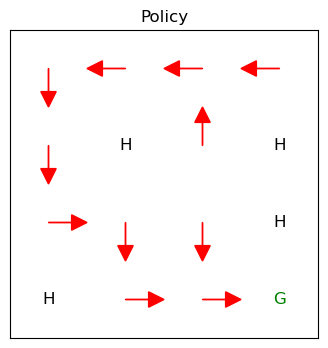

Q_max:67.0371540403557
Q_max:67.0371540403557
Q_max:67.0371540403557
Q_max:67.0371540403557
Q_max:67.0371540403557
Q_max:67.0371540403557
Q_max:67.0371540403557
Q_max:67.0371540403557
Q_max:67.0371540403557
Q_max:67.0371540403557
Q_max:67.0371540403557
Q_max:67.0371540403557
Q_max:67.0371540403557
Q_max:67.0371540403557
Q_max:67.0371540403557
Q_max:67.0371540403557
Q_max:67.0371540403557
Q_max:67.0371540403557
Q_max:67.0371540403557
Q_max:67.0371540403557
Q_max:67.0371540403557
Q_max:67.0371540403557
Q for cycle finished
Q_max:67.33149978729932
Q_max:67.33149978729932
Q_max:67.33149978729932
Q_max:67.33149978729932
Q_max:67.33149978729932
Q_max:67.33149978729932
Q_max:67.33149978729932
Q_max:67.33149978729932
Q_max:67.33149978729932
Q_max:67.33149978729932
Q_max:67.33149978729932
Q_max:67.33149978729932
Q_max:67.33149978729932
Q_max:67.33149978729932
Q_max:67.33149978729932
Q_max:67.33149978729932
Q_max:67.33149978729932
Q_max:67.33149978729932
Q_max:67.33149978729932
Q_max:67.33149978

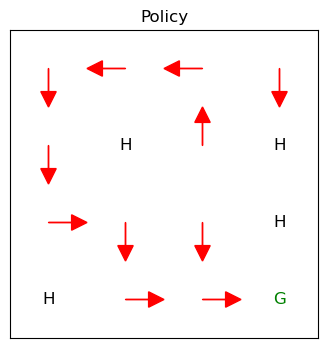

Q_max:68.51361590908685
Q_max:68.51361590908685
Q_max:68.51361590908685
Q_max:68.51361590908685
Q_max:68.51361590908685
Q_max:68.51361590908685
Q_max:68.51361590908685
Q_max:68.51361590908685
Q_max:68.51361590908685
Q_max:68.51361590908685
Q_max:68.51361590908685
Q_max:68.51361590908685
Q_max:68.51361590908685
Q_max:68.51361590908685
Q_max:68.51361590908685
Q_max:68.51361590908685
Q_max:68.51361590908685
Q_max:68.51361590908685
Q_max:68.51361590908685
Q_max:68.51361590908685
Q_max:68.51361590908685
Q_max:68.51361590908685
Q for cycle finished
Q_max:68.80728997187977
Q_max:68.80728997187977
Q_max:68.80728997187977
Q_max:68.80728997187977
Q_max:68.80728997187977
Q_max:68.80728997187977
Q_max:68.80728997187977
Q_max:68.80728997187977
Q_max:68.80728997187977
Q_max:68.80728997187977
Q_max:68.80728997187977
Q_max:68.80728997187977
Q_max:68.80728997187977
Q_max:68.80728997187977
Q_max:68.80728997187977
Q_max:68.80728997187977
Q_max:68.80728997187977
Q_max:68.80728997187977
Q_max:68.8072899718

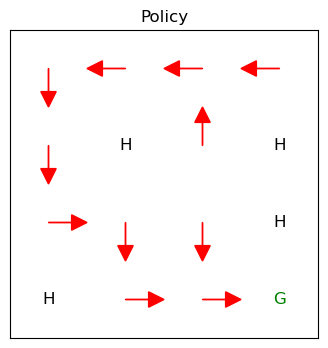

Q_max:69.85350061489761
Q_max:69.85350061489761
Q_max:69.85350061489761
Q_max:69.85350061489761
Q_max:69.85350061489761
Q_max:69.85350061489761
Q_max:69.85350061489761
Q_max:69.85350061489761
Q_max:69.85350061489761
Q_max:69.85350061489761
Q_max:69.85350061489761
Q_max:69.85350061489761
Q_max:69.85350061489761
Q_max:69.85350061489761
Q_max:69.85350061489761
Q_max:69.85350061489761
Q_max:69.85350061489761
Q_max:69.85350061489761
Q_max:69.85350061489761
Q for cycle finished
Q_max:70.14070979229662
Q_max:70.14070979229662
Q_max:70.14070979229662
Q_max:70.14070979229662
Q_max:70.14070979229662
Q_max:70.14070979229662
Q_max:70.14070979229662
Q_max:70.14070979229662
Q_max:70.14070979229662
Q_max:70.14070979229662
Q_max:70.14070979229662
Q_max:70.14070979229662
Q_max:70.14070979229662
Q_max:70.14070979229662
Q_max:70.14070979229662
Q_max:70.14070979229662
Q_max:70.14070979229662
Q_max:70.14070979229662
Q_max:70.14070979229662
Q for cycle finished
Q_max:70.37831077281514
Q_max:70.3783107728151

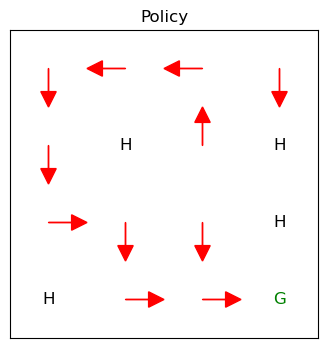

Q_max:0.0
Q for cycle finished
Q_max:71.13851205933548
Q_max:71.13851205933548
Q_max:71.13851205933548
Q_max:71.13851205933548
Q_max:71.13851205933548
Q_max:71.13851205933548
Q_max:71.13851205933548
Q_max:71.13851205933548
Q_max:71.13851205933548
Q_max:71.13851205933548
Q_max:71.13851205933548
Q_max:71.13851205933548
Q_max:71.13851205933548
Q_max:71.13851205933548
Q_max:71.13851205933548
Q_max:71.13851205933548
Q_max:71.13851205933548
Q_max:71.13851205933548
Q_max:71.13851205933548
Q_max:71.13851205933548
Q_max:71.13851205933548
Q_max:71.13851205933548
Q for cycle finished
Q_max:71.38171937785319
Q_max:71.38171937785319
Q_max:71.38171937785319
Q_max:71.38171937785319
Q_max:71.38171937785319
Q_max:71.38171937785319
Q_max:71.38171937785319
Q_max:71.38171937785319
Q_max:71.38171937785319
Q_max:71.38171937785319
Q_max:71.38171937785319
Q_max:71.38171937785319
Q_max:71.38171937785319
Q_max:71.38171937785319
Q_max:71.38171937785319
Q_max:71.38171937785319
Q_max:71.38171937785319
Q_max:71.381

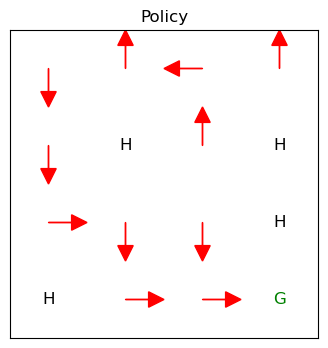

Q_max:71.89106497043136
Q_max:71.89106497043136
Q_max:71.89106497043136
Q_max:71.89106497043136
Q_max:71.89106497043136
Q_max:71.89106497043136
Q_max:71.89106497043136
Q_max:71.89106497043136
Q_max:71.89106497043136
Q_max:71.89106497043136
Q_max:71.89106497043136
Q_max:71.89106497043136
Q_max:71.89106497043136
Q_max:71.89106497043136
Q_max:71.89106497043136
Q_max:71.89106497043136
Q_max:71.89106497043136
Q_max:71.89106497043136
Q_max:71.89106497043136
Q_max:71.89106497043136
Q_max:71.89106497043136
Q_max:71.89106497043136
Q_max:71.89106497043136
Q for cycle finished
Q_max:72.12626640691613
Q_max:72.12626640691613
Q_max:72.12626640691613
Q_max:72.12626640691613
Q_max:72.12626640691613
Q_max:72.12626640691613
Q_max:72.12626640691613
Q_max:72.12626640691613
Q_max:72.12626640691613
Q_max:72.12626640691613
Q_max:72.12626640691613
Q_max:72.12626640691613
Q_max:72.12626640691613
Q_max:72.12626640691613
Q_max:72.12626640691613
Q_max:72.12626640691613
Q_max:72.12626640691613
Q_max:72.1262664069

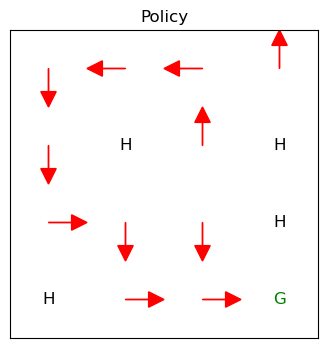

Q_max:0.0
Q for cycle finished
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q_max:73.0817595130682
Q for cycle finished
Q_max:73.30429398633343
Q_max:73.30429398633343
Q_max:73.30429398633343
Q_max:73.30429398633343
Q_max:73.30429398633343
Q_max:73.30429398633343
Q_max:73.30429398633343
Q_max:73.30429398633343
Q_max:73.30429398633343
Q_max:73.30429398633343
Q_max:73.30429398633343
Q_max:73.30429398633343
Q_max:73.30429398633343
Q_max:73.30429398633343
Q_max:73.30429398633343
Q_max:73.3042

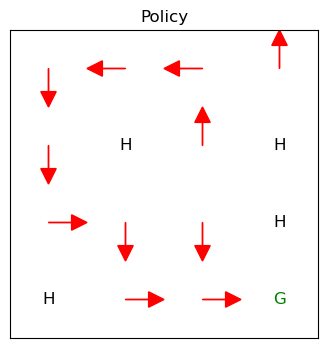

Q_max:73.9902627138733
Q_max:73.9902627138733
Q_max:73.9902627138733
Q_max:73.9902627138733
Q_max:73.9902627138733
Q_max:73.9902627138733
Q_max:73.9902627138733
Q_max:73.9902627138733
Q_max:73.9902627138733
Q_max:73.9902627138733
Q_max:73.9902627138733
Q_max:73.9902627138733
Q_max:73.9902627138733
Q_max:73.9902627138733
Q_max:73.9902627138733
Q_max:73.9902627138733
Q_max:73.9902627138733
Q_max:73.9902627138733
Q_max:73.9902627138733
Q for cycle finished
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195308106038
Q_max:74.2195

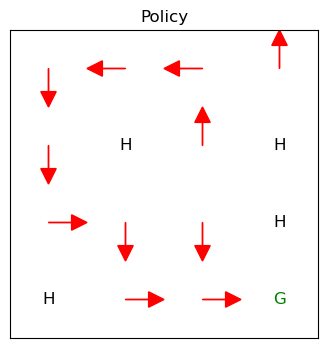

Q_max:75.10363945982527
Q_max:75.10363945982527
Q_max:75.10363945982527
Q_max:75.10363945982527
Q_max:75.10363945982527
Q_max:75.10363945982527
Q_max:75.10363945982527
Q_max:75.10363945982527
Q_max:75.10363945982527
Q_max:75.10363945982527
Q_max:75.10363945982527
Q_max:75.10363945982527
Q_max:75.10363945982527
Q_max:75.10363945982527
Q_max:75.10363945982527
Q_max:75.10363945982527
Q_max:75.10363945982527
Q_max:75.10363945982527
Q_max:75.10363945982527
Q for cycle finished
Q_max:75.32937513549717
Q_max:75.32937513549717
Q_max:75.32937513549717
Q_max:75.32937513549717
Q_max:75.32937513549717
Q_max:75.32937513549717
Q_max:75.32937513549717
Q_max:75.32937513549717
Q_max:75.32937513549717
Q_max:75.32937513549717
Q_max:75.32937513549717
Q_max:75.32937513549717
Q_max:75.32937513549717
Q_max:75.32937513549717
Q_max:75.32937513549717
Q_max:75.32937513549717
Q_max:75.32937513549717
Q_max:75.32937513549717
Q for cycle finished
Q_max:75.52799880426848
Q_max:75.52799880426848
Q_max:75.5279988042684

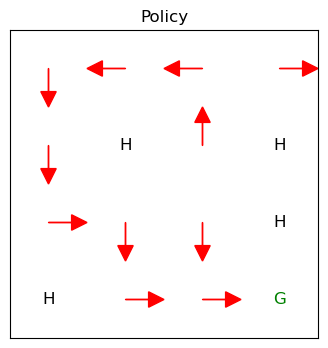

Q_max:76.10165206797726
Q_max:76.10165206797726
Q_max:76.10165206797726
Q_max:76.10165206797726
Q_max:76.10165206797726
Q_max:76.10165206797726
Q_max:76.10165206797726
Q_max:76.10165206797726
Q_max:76.10165206797726
Q_max:76.10165206797726
Q_max:76.10165206797726
Q_max:76.10165206797726
Q_max:76.10165206797726
Q_max:76.10165206797726
Q_max:76.10165206797726
Q_max:76.10165206797726
Q_max:76.10165206797726
Q_max:76.10165206797726
Q_max:76.10165206797726
Q_max:76.10165206797726
Q_max:76.10165206797726
Q for cycle finished
Q_max:76.32510459789586
Q_max:76.32510459789586
Q_max:76.32510459789586
Q_max:76.32510459789586
Q_max:76.32510459789586
Q_max:76.32510459789586
Q_max:76.32510459789586
Q_max:76.32510459789586
Q_max:76.32510459789586
Q_max:76.32510459789586
Q_max:76.32510459789586
Q_max:76.32510459789586
Q_max:76.32510459789586
Q_max:76.32510459789586
Q_max:76.32510459789586
Q_max:76.32510459789586
Q_max:76.32510459789586
Q_max:76.32510459789586
Q_max:76.32510459789586
Q_max:76.3251045978

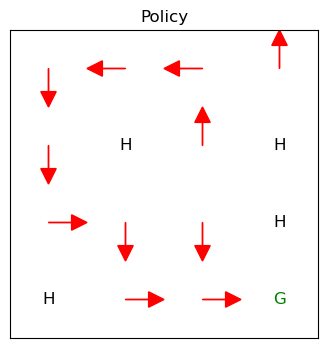

Q_max:77.15604807036672
Q_max:77.15604807036672
Q_max:77.15604807036672
Q_max:77.15604807036672
Q_max:77.15604807036672
Q_max:77.15604807036672
Q_max:77.15604807036672
Q_max:77.15604807036672
Q_max:77.15604807036672
Q_max:77.15604807036672
Q_max:77.15604807036672
Q_max:77.15604807036672
Q_max:77.15604807036672
Q_max:77.15604807036672
Q_max:77.15604807036672
Q_max:77.15604807036672
Q_max:77.15604807036672
Q for cycle finished
Q_max:77.32641314487891
Q_max:77.32641314487891
Q_max:77.32641314487891
Q_max:77.32641314487891
Q_max:77.32641314487891
Q_max:77.32641314487891
Q_max:77.32641314487891
Q_max:77.32641314487891
Q_max:77.32641314487891
Q_max:77.32641314487891
Q_max:77.32641314487891
Q_max:77.32641314487891
Q_max:77.32641314487891
Q_max:77.32641314487891
Q_max:77.32641314487891
Q_max:77.32641314487891
Q_max:77.32641314487891
Q for cycle finished
Q_max:77.52092967461975
Q_max:77.52092967461975
Q_max:77.52092967461975
Q_max:77.52092967461975
Q_max:77.52092967461975
Q_max:77.5209296746197

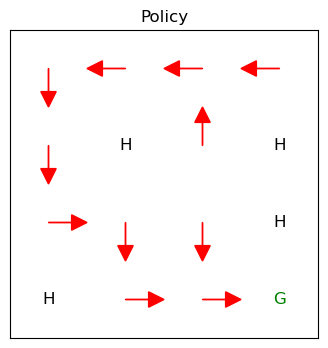

Q_max:78.1244984797187
Q_max:78.1244984797187
Q_max:78.1244984797187
Q_max:78.1244984797187
Q_max:78.1244984797187
Q_max:78.1244984797187
Q_max:78.1244984797187
Q_max:78.1244984797187
Q_max:78.1244984797187
Q_max:78.1244984797187
Q_max:78.1244984797187
Q_max:78.1244984797187
Q_max:78.1244984797187
Q_max:78.1244984797187
Q_max:78.1244984797187
Q_max:78.1244984797187
Q_max:78.1244984797187
Q_max:78.1244984797187
Q for cycle finished
Q_max:78.31070162055497
Q_max:78.31070162055497
Q_max:78.31070162055497
Q_max:78.31070162055497
Q_max:78.31070162055497
Q_max:78.31070162055497
Q_max:78.31070162055497
Q_max:78.31070162055497
Q_max:78.31070162055497
Q_max:78.31070162055497
Q_max:78.31070162055497
Q_max:78.31070162055497
Q_max:78.31070162055497
Q_max:78.31070162055497
Q_max:78.31070162055497
Q_max:78.31070162055497
Q_max:78.31070162055497
Q_max:78.31070162055497
Q_max:78.31070162055497
Q for cycle finished
Q_max:78.45949834207067
Q_max:78.45949834207067
Q_max:78.45949834207067
Q_max:78.4594983

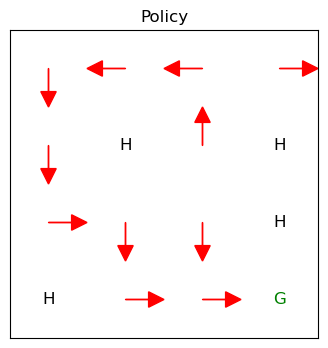

Q_max:78.82273608668972
Q_max:78.82273608668972
Q_max:78.82273608668972
Q_max:78.82273608668972
Q_max:78.82273608668972
Q_max:78.82273608668972
Q_max:78.82273608668972
Q_max:78.82273608668972
Q_max:78.82273608668972
Q_max:78.82273608668972
Q_max:78.82273608668972
Q_max:78.82273608668972
Q_max:78.82273608668972
Q_max:78.82273608668972
Q_max:78.82273608668972
Q_max:78.82273608668972
Q_max:78.82273608668972
Q for cycle finished
Q_max:78.95655217364917
Q_max:78.95655217364917
Q_max:78.95655217364917
Q_max:78.95655217364917
Q_max:78.95655217364917
Q_max:78.95655217364917
Q_max:78.95655217364917
Q_max:78.95655217364917
Q_max:78.95655217364917
Q_max:78.95655217364917
Q_max:78.95655217364917
Q_max:78.95655217364917
Q_max:78.95655217364917
Q_max:78.95655217364917
Q_max:78.95655217364917
Q_max:78.95655217364917
Q_max:78.95655217364917
Q_max:78.95655217364917
Q_max:78.95655217364917
Q_max:78.95655217364917
Q_max:78.95655217364917
Q_max:78.95655217364917
Q_max:78.95655217364917
Q for cycle finishe

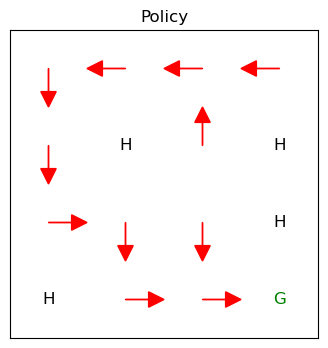

Q_max:79.67207974834359
Q_max:79.67207974834359
Q_max:79.67207974834359
Q_max:79.67207974834359
Q_max:79.67207974834359
Q_max:79.67207974834359
Q_max:79.67207974834359
Q_max:79.67207974834359
Q_max:79.67207974834359
Q_max:79.67207974834359
Q_max:79.67207974834359
Q_max:79.67207974834359
Q_max:79.67207974834359
Q_max:79.67207974834359
Q_max:79.67207974834359
Q_max:79.67207974834359
Q_max:79.67207974834359
Q_max:79.67207974834359
Q_max:79.67207974834359
Q_max:79.67207974834359
Q_max:79.67207974834359
Q_max:79.67207974834359
Q for cycle finished
Q_max:0.0
Q for cycle finished
Q_max:79.82450443187184
Q_max:79.82450443187184
Q_max:79.82450443187184
Q_max:79.82450443187184
Q_max:79.82450443187184
Q_max:79.82450443187184
Q_max:79.82450443187184
Q_max:79.82450443187184
Q_max:79.82450443187184
Q_max:79.82450443187184
Q_max:79.82450443187184
Q_max:79.82450443187184
Q_max:79.82450443187184
Q_max:79.82450443187184
Q_max:79.82450443187184
Q_max:79.82450443187184
Q_max:79.82450443187184
Q_max:79.824

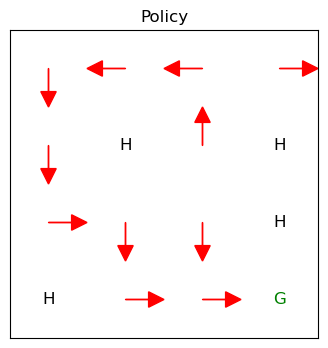

Q_max:80.15973876927553
Q_max:80.15973876927553
Q_max:80.15973876927553
Q_max:80.15973876927553
Q_max:80.15973876927553
Q_max:80.15973876927553
Q_max:80.15973876927553
Q_max:80.15973876927553
Q_max:80.15973876927553
Q_max:80.15973876927553
Q_max:80.15973876927553
Q_max:80.15973876927553
Q_max:80.15973876927553
Q_max:80.15973876927553
Q_max:80.15973876927553
Q_max:80.15973876927553
Q_max:80.15973876927553
Q_max:80.15973876927553
Q_max:80.15973876927553
Q_max:80.15973876927553
Q_max:80.15973876927553
Q for cycle finished
Q_max:80.30697559087899
Q_max:80.30697559087899
Q_max:80.30697559087899
Q_max:80.30697559087899
Q_max:80.30697559087899
Q_max:80.30697559087899
Q_max:80.30697559087899
Q_max:80.30697559087899
Q_max:80.30697559087899
Q_max:80.30697559087899
Q_max:80.30697559087899
Q_max:80.30697559087899
Q_max:80.30697559087899
Q_max:80.30697559087899
Q_max:80.30697559087899
Q_max:80.30697559087899
Q_max:80.30697559087899
Q_max:80.30697559087899
Q for cycle finished
Q_max:80.4434597243104

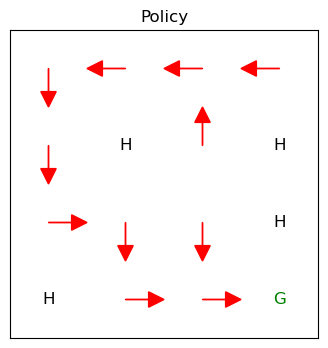

Q_max:80.88768905877481
Q_max:80.88768905877481
Q_max:80.88768905877481
Q_max:80.88768905877481
Q_max:80.88768905877481
Q_max:80.88768905877481
Q_max:80.88768905877481
Q_max:80.88768905877481
Q_max:80.88768905877481
Q_max:80.88768905877481
Q_max:80.88768905877481
Q_max:80.88768905877481
Q_max:80.88768905877481
Q_max:80.88768905877481
Q_max:80.88768905877481
Q_max:80.88768905877481
Q_max:80.88768905877481
Q_max:80.88768905877481
Q_max:80.88768905877481
Q_max:80.88768905877481
Q_max:80.88768905877481
Q for cycle finished
Q_max:81.03623970026139
Q_max:81.03623970026139
Q_max:81.03623970026139
Q_max:81.03623970026139
Q_max:81.03623970026139
Q_max:81.03623970026139
Q_max:81.03623970026139
Q_max:81.03623970026139
Q_max:81.03623970026139
Q_max:81.03623970026139
Q_max:81.03623970026139
Q_max:81.03623970026139
Q_max:81.03623970026139
Q_max:81.03623970026139
Q_max:81.03623970026139
Q_max:81.03623970026139
Q_max:81.03623970026139
Q_max:81.03623970026139
Q for cycle finished
Q_max:81.2008145487123

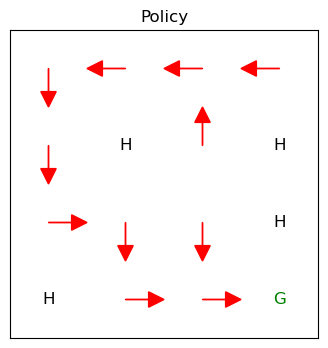

Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q_max:81.61354157932885
Q for cycle finished
Q_max:81.77216486201618
Q_max:81.77216486201618
Q_max:81.77216486201618
Q_max:81.77216486201618
Q_max:81.77216486201618
Q_max:81.77216486201618
Q_max:81.77216486201618
Q_max:81.77216486201618
Q_max:81.77216486201618
Q_max:81.77216486201618
Q_max:81.77216486201618
Q_max:81.77216486201618
Q_max:81.77216486201618
Q_max:81.77216486201618
Q_max:81.77216486201618
Q_max:81.7721648620

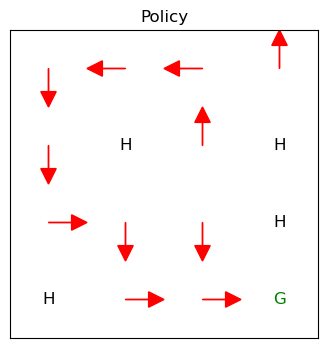

Q_max:82.35582390655117
Q_max:82.35582390655117
Q_max:82.35582390655117
Q_max:82.35582390655117
Q_max:82.35582390655117
Q_max:82.35582390655117
Q_max:82.35582390655117
Q_max:82.35582390655117
Q_max:82.35582390655117
Q_max:82.35582390655117
Q_max:82.35582390655117
Q_max:82.35582390655117
Q_max:82.35582390655117
Q_max:82.35582390655117
Q_max:82.35582390655117
Q_max:82.35582390655117
Q_max:82.35582390655117
Q for cycle finished
Q_max:82.49795074085793
Q_max:82.49795074085793
Q_max:82.49795074085793
Q_max:82.49795074085793
Q_max:82.49795074085793
Q_max:82.49795074085793
Q_max:82.49795074085793
Q_max:82.49795074085793
Q_max:82.49795074085793
Q_max:82.49795074085793
Q_max:82.49795074085793
Q_max:82.49795074085793
Q_max:82.49795074085793
Q_max:82.49795074085793
Q_max:82.49795074085793
Q_max:82.49795074085793
Q_max:82.49795074085793
Q_max:82.49795074085793
Q_max:82.49795074085793
Q_max:82.49795074085793
Q_max:82.49795074085793
Q for cycle finished
Q_max:82.62031296701902
Q_max:82.6203129670190

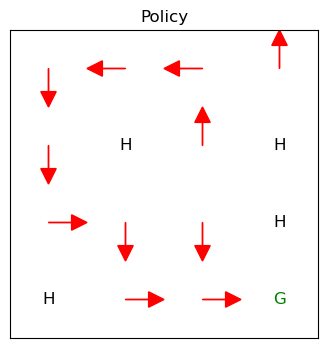

Q_max:82.9064920811011
Q_max:82.9064920811011
Q_max:82.9064920811011
Q_max:82.9064920811011
Q_max:82.9064920811011
Q_max:82.9064920811011
Q_max:82.9064920811011
Q_max:82.9064920811011
Q_max:82.9064920811011
Q_max:82.9064920811011
Q_max:82.9064920811011
Q_max:82.9064920811011
Q_max:82.9064920811011
Q_max:82.9064920811011
Q_max:82.9064920811011
Q_max:82.9064920811011
Q for cycle finished
Q_max:83.02450812279152
Q_max:83.02450812279152
Q_max:83.02450812279152
Q_max:83.02450812279152
Q_max:83.02450812279152
Q_max:83.02450812279152
Q_max:83.02450812279152
Q_max:83.02450812279152
Q_max:83.02450812279152
Q_max:83.02450812279152
Q_max:83.02450812279152
Q_max:83.02450812279152
Q_max:83.02450812279152
Q_max:83.02450812279152
Q_max:83.02450812279152
Q_max:83.02450812279152
Q_max:83.02450812279152
Q_max:83.02450812279152
Q_max:83.02450812279152
Q_max:83.02450812279152
Q_max:83.02450812279152
Q for cycle finished
Q_max:83.16858535863902
Q_max:83.16858535863902
Q_max:83.16858535863902
Q_max:83.16858

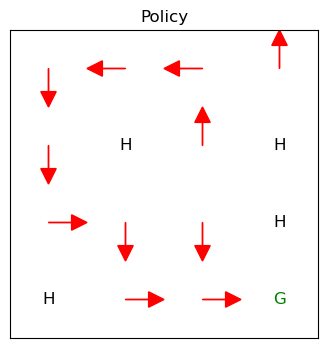

Q_max:83.55609252506864
Q_max:83.55609252506864
Q_max:83.55609252506864
Q_max:83.55609252506864
Q_max:83.55609252506864
Q_max:83.55609252506864
Q_max:83.55609252506864
Q_max:83.55609252506864
Q_max:83.55609252506864
Q_max:83.55609252506864
Q_max:83.55609252506864
Q_max:83.55609252506864
Q_max:83.55609252506864
Q_max:83.55609252506864
Q_max:83.55609252506864
Q_max:83.55609252506864
Q_max:83.55609252506864
Q_max:83.55609252506864
Q_max:83.55609252506864
Q_max:83.55609252506864
Q_max:83.55609252506864
Q for cycle finished
Q_max:83.65763991727219
Q_max:83.65763991727219
Q_max:83.65763991727219
Q_max:83.65763991727219
Q_max:83.65763991727219
Q_max:83.65763991727219
Q_max:83.65763991727219
Q_max:83.65763991727219
Q_max:83.65763991727219
Q_max:83.65763991727219
Q_max:83.65763991727219
Q_max:83.65763991727219
Q_max:83.65763991727219
Q_max:83.65763991727219
Q_max:83.65763991727219
Q_max:83.65763991727219
Q_max:83.65763991727219
Q_max:83.65763991727219
Q_max:83.65763991727219
Q_max:83.6576399172

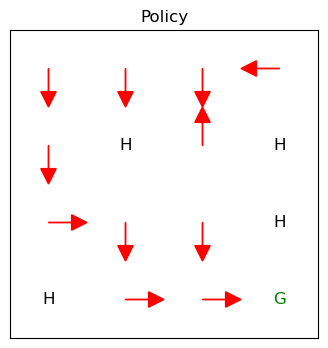

Q_max:84.13671882854064
Q_max:84.13671882854064
Q_max:84.13671882854064
Q_max:84.13671882854064
Q_max:84.13671882854064
Q_max:84.13671882854064
Q_max:84.13671882854064
Q_max:84.13671882854064
Q_max:84.13671882854064
Q_max:84.13671882854064
Q_max:84.13671882854064
Q_max:84.13671882854064
Q_max:84.13671882854064
Q_max:84.13671882854064
Q_max:84.13671882854064
Q_max:84.13671882854064
Q_max:84.13671882854064
Q_max:84.13671882854064
Q_max:84.13671882854064
Q_max:84.13671882854064
Q_max:84.13671882854064
Q_max:84.13671882854064
Q for cycle finished
Q_max:84.26029467407668
Q_max:84.26029467407668
Q_max:84.26029467407668
Q_max:84.26029467407668
Q_max:84.26029467407668
Q_max:84.26029467407668
Q_max:84.26029467407668
Q_max:84.26029467407668
Q_max:84.26029467407668
Q_max:84.26029467407668
Q_max:84.26029467407668
Q_max:84.26029467407668
Q_max:84.26029467407668
Q_max:84.26029467407668
Q_max:84.26029467407668
Q_max:84.26029467407668
Q_max:84.26029467407668
Q_max:84.26029467407668
Q_max:84.2602946740

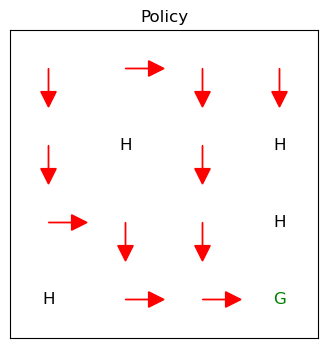

Q_max:84.70481608556032
Q_max:84.70481608556032
Q_max:84.70481608556032
Q_max:84.70481608556032
Q_max:84.70481608556032
Q_max:84.70481608556032
Q_max:84.70481608556032
Q_max:84.70481608556032
Q_max:84.70481608556032
Q_max:84.70481608556032
Q_max:84.70481608556032
Q_max:84.70481608556032
Q_max:84.70481608556032
Q_max:84.70481608556032
Q_max:84.70481608556032
Q_max:84.70481608556032
Q_max:84.70481608556032
Q_max:84.70481608556032
Q_max:84.70481608556032
Q_max:84.70481608556032
Q_max:84.70481608556032
Q for cycle finished
Q_max:84.79401161152204
Q_max:84.79401161152204
Q_max:84.79401161152204
Q_max:84.79401161152204
Q_max:84.79401161152204
Q_max:84.79401161152204
Q_max:84.79401161152204
Q_max:84.79401161152204
Q_max:84.79401161152204
Q_max:84.79401161152204
Q_max:84.79401161152204
Q_max:84.79401161152204
Q_max:84.79401161152204
Q_max:84.79401161152204
Q_max:84.79401161152204
Q_max:84.79401161152204
Q_max:84.79401161152204
Q_max:84.79401161152204
Q_max:84.79401161152204
Q_max:84.7940116115

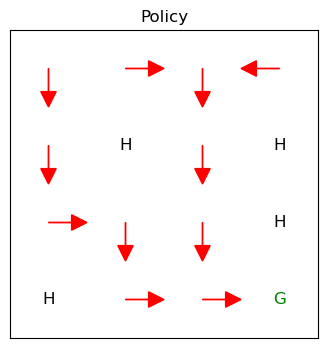

Q_max:85.21557562140389
Q_max:85.21557562140389
Q_max:85.21557562140389
Q_max:85.21557562140389
Q_max:85.21557562140389
Q_max:85.21557562140389
Q_max:85.21557562140389
Q_max:85.21557562140389
Q_max:85.21557562140389
Q_max:85.21557562140389
Q_max:85.21557562140389
Q_max:85.21557562140389
Q_max:85.21557562140389
Q_max:85.21557562140389
Q_max:85.21557562140389
Q_max:85.21557562140389
Q_max:85.21557562140389
Q_max:85.21557562140389
Q_max:85.21557562140389
Q_max:85.21557562140389
Q_max:85.21557562140389
Q for cycle finished
Q_max:85.31856956223122
Q_max:85.31856956223122
Q_max:85.31856956223122
Q_max:85.31856956223122
Q_max:85.31856956223122
Q_max:85.31856956223122
Q_max:85.31856956223122
Q_max:85.31856956223122
Q_max:85.31856956223122
Q_max:85.31856956223122
Q_max:85.31856956223122
Q_max:85.31856956223122
Q_max:85.31856956223122
Q_max:85.31856956223122
Q_max:85.31856956223122
Q_max:85.31856956223122
Q_max:85.31856956223122
Q_max:85.31856956223122
Q_max:85.31856956223122
Q_max:85.3185695622

In [24]:
# TODO: Extend this algorithm with a convergency check. 

num_states = env.observation_space.n
num_actions = env.action_space.n

gamma = 0.9
num_iterations = 300
num_episodes = 100 

epsilon = 0.05

# Hyperparameter for the convergence check: 
delta = 0.5

policy = np.random.randint(num_actions, size=num_states)

Q = np.zeros([num_states, num_actions])

for iteration in range(num_iterations):
    
    episode_count = 0
    steps = 0
    count_got_reward = 0     

    returns = {}  
    count = {}        
    
    while episode_count < num_episodes:
        state, _ = env.reset()
        episode = []       
        got_reward = False 
        truncated = False
        done = False

        while not (truncated or done):
            steps += 1 
            
            if np.random.uniform(0, 1) < epsilon:  
                action = env.action_space.sample()
            else:
                action = policy[state]            
            
            new_state, reward, done, truncated, _ = env.step(action)
            if reward > 0:
                got_reward = True 
             
            episode.append((state, action, reward))
            state = new_state
                      
                
        if got_reward:
            count_got_reward += 1
        episode_count += 1  
        
        acc_return = 0
        visited_pairs = set() 

        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            
            if (s, a) not in visited_pairs:
                visited_pairs.add((s, a)) 
                acc_return = r + gamma * acc_return 

                if (s, a) not in returns:
                    returns[(s, a)] = 0
                    count[(s, a)] = 0

                returns[(s, a)] += acc_return 
                count[(s, a)] += 1
                
    Q_max_change = 0.0
    for (s, a), total_return in returns.items():
        Q_change = Q[s, a]+ 1 / count[(s, a)]*(total_return - Q[s, a])
        
        Q_max_change = max(Q_max_change, Q_change)
        print(f"Q_max:{Q_max_change}")
        
        #Check if Q changed less than delta. If so - break out of both loops
        if Q_max_change < delta:
            break
            
        Q[s, a] = Q_change
    print("Q for cycle finished")


    for state in range(num_states):
        best_actions = np.argwhere(Q[state] == np.amax(Q[state])).flatten()
        policy[state] = np.random.choice(best_actions)
        
    if (iteration % 5 == 0):
        print(f"Policy after iteration: {iteration}")
        print(f"Got reward {count_got_reward} times.")
        plot_policy(policy)

## Exercise C4 (c) (1 Point)

The above algorithm (Monte Carlo Control with convergence check) terminates sometimes already after the first iteration. What is the reason for this behavior? 

Answer: TODO